# Revenue Modeling: Parking

**Purpose:** For the tax revenue of interest, explore forecasts, testing out different combinations of 
endog and exog variables.

Once the best fit is determined, we can plug the parameters into the main "parameters.yml" file and run reproducible model fits through the command line using `fyp-analysis run`.

In [1]:
TAX_NAME = "Parking"
TAX_BASE_COLUMN = f"{TAX_NAME}Base"

## Software Setup

If changes are made to the analysis code, run the below cell to reload the changes:

In [2]:
%reload_kedro

2021-07-05 13:36:50,737 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-07-05 13:36:50,901 - root - INFO - ** Kedro project Five Year Plan Analysis
2021-07-05 13:36:50,906 - root - INFO - Defined global variable `context`, `session` and `catalog`


Imports:

In [3]:
from fbprophet import Prophet

2021-07-05 13:36:51,836 - fbprophet.plot - ERROR - Importing plotly failed. Interactive plots will not work.


In [4]:
# Base imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from phila_style.matplotlib import get_theme
from phl_budget_data.clean import load_city_tax_collections

# Prediction functions
from fyp_analysis.pipelines.modeling.predict import (
    get_possible_endog_variables,
    run_possible_models,
    fit_var_model,
    plot_forecast_results,
    plot_projection_comparison,
    aggregate_to_fiscal_year,
    get_forecasts_from_fits,
)

# The main preprocess pipeline
from fyp_analysis.pipelines.data_processing.preprocess import PreprocessPipeline
from fyp_analysis.extras.datasets import load_cbo_data, Taxes

/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [5]:
pd.options.display.max_columns = 999

## Parameter Setup

Set up the data catalog. We can use `DATA.load()` to load specific data instances.

In [6]:
DATA = context.catalog

Available data:

In [7]:
DATA.list()

['economic_indicators',
 'quarterly_features_raw',
 'quarterly_features_cbo_imputed',
 'features_and_bases',
 'features_and_bases_sa',
 'stationary_guide',
 'final_unscaled_features',
 'final_scaled_features',
 'scaled_feature_correlations',
 'grangers_matrix',
 'possible_endog_variables',
 'plan_details',
 'wage_fit_params',
 'sales_fit_params',
 'net_income_fit_params',
 'gross_receipts_fit_params',
 'rtt_fit_params',
 'parking_fit_params',
 'amusement_fit_params',
 'npt_fit_params',
 'parameters',
 'params:fresh_indicators',
 'params:seasonal_adjustments',
 'params:min_feature_year',
 'params:max_fit_date',
 'params:grangers_maxlag',
 'params:grangers_max_date',
 'params:plan_start_year',
 'params:cbo_forecast_date']

Load the parameter dict too:

In [8]:
PARAMS = context.params

In [9]:
PARAMS

{'fresh_indicators': False,
 'seasonal_adjustments': ['ActivityLicensesPhilly',
  'BizLicensesPhilly',
  'BuildingPermitsPhilly',
  'CPIPhillyMSA',
  'ContinuedClaimsPA',
  'WeeklyEconomicIndex',
  'DeedTransfersPhilly',
  'InitialClaimsPA',
  'UncertaintyIndex',
  'UnemploymentPhilly'],
 'min_feature_year': 1996,
 'max_fit_date': '2021-06-30',
 'grangers_maxlag': 6,
 'grangers_max_date': '2019-12-31',
 'plan_start_year': 2022,
 'cbo_forecast_date': 'latest'}

Extract specific parameters:

In [10]:
# Trim features to this start year
min_year = PARAMS["min_feature_year"]

# When is the CBO forecast from?
cbo_forecast_date = PARAMS["cbo_forecast_date"]

# First fiscal year of the plan
plan_start_year = PARAMS["plan_start_year"]

## Data Setup

Load the correlation matrix and Granger matrix:

In [11]:
C = DATA.load("scaled_feature_correlations") # correlation matrix
G = DATA.load("grangers_matrix") # Granger matrix

2021-07-05 13:36:55,380 - kedro.io.data_catalog - INFO - Loading data from `scaled_feature_correlations` (ExcelDataSet)...
2021-07-05 13:36:55,768 - kedro.io.data_catalog - INFO - Loading data from `grangers_matrix` (ExcelDataSet)...


Load taxes object responsible for loading historical tax data"

In [12]:
# Load the Plan details we are using
plan_details = DATA.load("plan_details")

# All taxes
all_taxes = Taxes(plan_details)

# This tax
this_tax = all_taxes[TAX_NAME]

2021-07-05 13:36:55,848 - kedro.io.data_catalog - INFO - Loading data from `plan_details` (PlanDetailsYAMLDataSet)...


Data associated with a tax is stored in the `.data` attribute:

In [13]:
this_tax.data.head()

,fiscal_quarter,fiscal_year,ParkingRevenue,rate,ParkingBase
0,1,1996,6501851.38,0.15,4.334568e+07
1,2,1996,6901942.52,0.15,4.601295e+07
2,3,1996,6758306.27,0.15,4.505538e+07
3,4,1996,7177636.72,0.15,4.785091e+07
4,1,1997,6660426.76,0.15,4.440285e+07


Load the final unscaled features:

In [14]:
unscaled_features = DATA.load("final_unscaled_features")

2021-07-05 13:36:56,157 - kedro.io.data_catalog - INFO - Loading data from `final_unscaled_features` (CSVDataSet)...


In [15]:
unscaled_features.head()

,YieldCurve,SahmRule,WagesPhillyMSA,NonfarmEmployeesPhillyMSA,NonfarmEmployeesPhilly,PersonalSavingsRate,NYCGasPrice,CarSales,RealRetailFoodServiceSales,UnemploymentRate,PPI,UnemploymentPhillyMSA,UnemploymentPhilly,CorporateProfits,RealGDP,AlcoholSales,PrimeEPOP,UncertaintyIndex,HousePriceIndexPhillyMSA,BuildingPermitsPhillyMSA,EconomicConditionsPhillyMSA,CPIPhillyMSA,InitialClaimsPA,ContinuedClaimsPA,NewManufacturingOrders,ConsumerConfidence,ManufacturingHoursWorked,PCE,RealDisposablePersonalIncome,HousingStarts,HousingSupply,GovtSocialBenefits,GDPPriceIndex,GDP,PCEPriceIndex,CPIU,10YearTreasury,3MonthTreasury,FedFundsRate,OilPriceWTI,FHFAHousePriceIndex,NonfarmEmployment,PersonalIncome,Wage&Salaries,NonresidentialInvestment,ResidentialInvestment,TotalBusinessSales,SP500,MedianHomeValuePhilly,AmusementBase,GrossReceiptsBase,NetIncomeBase,NPTBase,ParkingBase,RTTBase,SalesBase,WageBase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.640323,0.133333,633.494864,2488.200000,673.300000,6.666667,0.540810,15.481000,136411.666667,5.533333,126.300000,5.666667,7.615251,772.255,10817.896,1929.333333,79.866667,85.211652,105.35,1192.461261,2.993333,161.128928,24286.348514,183207.426031,48964.666667,100.506111,40.700000,5130.600000,7867.333333,1460.666667,5.966667,674.991,72.700,7868.468,72.700000,155.066667,5.910000,4.930000,5.363333,19.760000,113.72,118682.666667,6520.965,3524.466667,1003.747,344.725,665407.333333,637.010000,70409.666667,25221361.2,2.187766e+08,2.247482e+08,3.846310e+07,4.505538e+07,4.173158e+08,2.202701e+09,5.879433e+09
1996-04-01,0.603281,-0.023333,634.204732,2518.700000,673.933333,6.500000,0.641175,15.571667,137903.333333,5.500000,127.833333,5.466667,7.303317,784.776,10998.322,1930.666667,80.000000,76.013567,103.48,1419.918127,4.320000,162.290804,21465.862561,162774.104738,50054.333333,100.703103,41.366667,5220.533333,7939.400000,1495.666667,5.966667,680.667,72.997,8032.840,73.186667,156.400000,6.720000,5.020000,5.243333,21.696667,114.47,119471.000000,6649.846,3589.933333,1026.468,361.399,683338.666667,658.966667,70070.666667,36110132.0,1.794259e+09,1.843234e+09,2.124595e+08,4.785091e+07,3.134791e+08,1.707329e+09,5.672519e+09
1996-07-01,0.600000,-0.066667,634.799371,2526.300000,675.900000,6.666667,0.616141,15.364667,138152.333333,5.266667,128.166667,5.366667,7.134090,790.044,11096.976,1944.000000,80.433333,76.992374,102.40,1450.454374,2.470000,163.260178,20989.538331,156320.048762,50550.333333,101.087051,41.500000,5274.500000,8003.700000,1501.333333,5.300000,683.711,73.352,8131.408,73.498667,157.300000,6.780000,5.096667,5.306667,22.390000,115.21,120208.000000,6725.853,3647.233333,1058.965,364.315,690877.000000,660.543333,69872.333333,45949333.4,1.363051e+08,1.376918e+08,1.790954e+07,4.440285e+07,4.318287e+08,2.141674e+09,5.718973e+09
1996-10-01,0.550484,0.033333,645.667612,2537.900000,672.033333,6.400000,0.676531,15.401000,139499.000000,5.333333,128.433333,5.266667,7.227878,810.914,11212.205,1906.666667,80.533333,62.134681,103.38,1585.019678,3.286667,164.630069,21427.940357,153523.202698,51995.000000,101.427253,41.533333,5352.766667,8046.366667,1417.000000,5.266667,688.911,73.662,8259.771,73.999333,158.666667,6.343333,4.976667,5.280000,24.606667,115.87,120923.000000,6817.457,3704.266667,1083.597,361.806,699627.333333,726.793333,69969.333333,56777070.2,4.502762e+07,4.548571e+07,2.239441e+07,4.687521e+07,5.769549e+08,2.126915e+09,5.793457e+09
1997-01-01,0.522333,0.120000,651.303280,2556.266667,666.600000,6.266667,0.638361,15.589667,140960.666667,5.233333,128.500000,5.100000,7.045607,839.036,11284.587,1950.333333,80.500000,58.548248,103.72,1665.828907,3.503333,165.722588,18587.041742,149251.881603,53479.333333,101.677271,41.600000,5433.100000,8123.000000,1432.666667,4.433333,704.464,73.992,8362.655,74.326000,159.633333,6.563333,5.060000,5.276667,22.760000,116.60,121676.000000,6939.356,3776.366667,1107.299,365.359,713321.666667,785.590000,70345.666667,26804719.4,2.626964e+08,2.653690e+08,4.589743

The final scaled features:

In [16]:
scaled_features = DATA.load("final_scaled_features")

2021-07-05 13:36:56,367 - kedro.io.data_catalog - INFO - Loading data from `final_scaled_features` (CSVDataSet)...


In [17]:
scaled_features.head()

,D.YieldCurve,D.SahmRule,D.D.Ln.WagesPhillyMSA,D.Ln.NonfarmEmployeesPhillyMSA,D.Ln.NonfarmEmployeesPhilly,D.Ln.PersonalSavingsRate,D.Ln.NYCGasPrice,D.Ln.CarSales,D.Ln.RealRetailFoodServiceSales,D.Ln.UnemploymentRate,D.Ln.PPI,D.Ln.UnemploymentPhillyMSA,D.Ln.UnemploymentPhilly,D.Ln.CorporateProfits,D.Ln.RealGDP,D.Ln.AlcoholSales,D.Ln.PrimeEPOP,D.Ln.UncertaintyIndex,D.D.Ln.HousePriceIndexPhillyMSA,D.Ln.BuildingPermitsPhillyMSA,D.EconomicConditionsPhillyMSA,D.Ln.CPIPhillyMSA,D.Ln.InitialClaimsPA,D.Ln.ContinuedClaimsPA,D.Ln.NewManufacturingOrders,D.Ln.ConsumerConfidence,D.Ln.ManufacturingHoursWorked,D.Ln.PCE,D.Ln.RealDisposablePersonalIncome,D.Ln.HousingStarts,D.Ln.HousingSupply,D.D.Ln.GovtSocialBenefits,D.Ln.GDPPriceIndex,D.Ln.GDP,D.Ln.PCEPriceIndex,D.Ln.CPIU,D.Ln.10YearTreasury,D.Ln.3MonthTreasury,D.Ln.FedFundsRate,D.Ln.OilPriceWTI,D.Ln.FHFAHousePriceIndex,D.Ln.NonfarmEmployment,D.Ln.PersonalIncome,D.Ln.Wage&Salaries,D.Ln.NonresidentialInvestment,D.Ln.ResidentialInvestment,D.Ln.TotalBusinessSales,D.Ln.SP500,D.D.Ln.MedianHomeValuePhilly,D.Ln.AmusementBase,D.GrossReceiptsBase,D.NetIncomeBase,D.NPTBase,D.Ln.ParkingBase,D.Ln.RTTBase,D.Ln.SalesBase,D.Ln.WageBase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-01-01,-0.028151,0.086667,-0.008285,0.007211,-0.008118,-0.021053,-0.058075,0.012176,0.010423,-0.018928,0.000519,-0.032157,-0.025541,0.034092,0.006435,0.022644,-0.000414,-0.059453,-0.006241,0.049726,0.216667,0.006614,-0.142231,-0.028216,0.028148,0.002462,0.001604,0.014896,0.009479,0.010996,-0.172246,0.014748,0.004470,0.012379,0.004405,0.006074,0.034094,0.016606,-0.000632,-0.078013,0.006280,0.006208,0.017722,0.019277,0.021638,0.009772,0.019385,0.077793,0.003977,-0.750555,0.043920,0.040621,0.074343,-0.016236,-0.369991,0.075583,0.049908
1997-04-01,-0.098583,-0.223333,-0.005558,0.005163,-0.001902,0.056863,-0.084651,-0.045918,-0.004463,-0.045611,-0.010168,-0.033226,-0.014045,0.026578,0.016483,0.021473,0.002894,0.299199,-0.006567,-0.090230,-0.070000,0.002961,0.087875,-0.030346,0.027674,0.005314,0.002401,0.006994,0.008829,0.029798,0.029632,-0.017957,0.004975,0.018502,0.002504,0.002294,0.020111,-0.002639,0.045687,-0.132946,0.008115,0.007146,0.011878,0.015572,0.019911,0.018758,0.006936,0.048265,-0.001109,0.674485,0.167152,0.138132,-0.018271,0.089694,-0.014438,-0.094648,-0.047583
1997-07-01,-0.085312,0.103333,0.012688,0.008757,0.001302,-0.083819,0.083351,0.046837,0.016635,-0.027029,0.000000,-0.041385,-0.007421,0.039824,0.012431,0.011972,0.005353,-0.268545,0.012143,-0.023355,0.820000,0.004391,0.017352,-0.014462,0.072510,0.003295,-0.000800,0.019535,0.011695,-0.012499,-0.060169,-0.002059,0.002954,0.016762,0.002636,0.004988,-0.070096,0.000000,0.001809,-0.006209,0.007289,0.005812,0.015969,0.017402,0.042293,0.017771,0.015111,0.120323,-0.001461,-0.143395,-0.018339,-0.021556,0.048985,-0.087370,0.410222,0.288893,0.039920
1997-10-01,-0.166663,-0.066667,0.012970,0.008464,0.009511,0.037538,-0.141757,0.019421,-0.000832,-0.041964,0.002356,-0.035846,-0.044643,-0.016932,0.008551,0.018992,-0.001644,0.130184,0.001062,0.056339,-0.476667,-0.000259,0.007374,0.016934,-0.019323,-0.000241,0.004789,0.015026,0.014623,0.049737,-0.023530,-0.000816,0.003574,0.011829,0.003132,0.005375,-0.055433,0.008550,-0.004831,0.007379,0.010752,0.007876,0.019115,0.022656,0.002339,0.017790,0.006278,0.022298,-0.005815,0.317877,0.063651,0.061508,-0.060980,0.064860,0.187705,-0.223446,0.016527
1998-01-01,-0.030463,0.056667,-0.039897,0.005303,0.003315,0.160148,-0.189621,-0.049476,0.004998,-0.007168,-0.019536,-0.029632,-0.002417,-0.081392,0.009945,0.014810,-0.000411,0.227152,0.008234,0.189062,-1.206667,0.001211,0.012982,-0.016309,-0.000604,0.002640,-0.003190,0.010136,0.020831,0.017257,-0.048790,0.011728,0.001015,0.011408,0.000076,0.002060,-0.055699,-0.007230,0.002418,-0.222726,0.012372,0.006096,0.021968,0.020454,0.026118,0.023296,0.005541,0.071520,-0.000397,-0.638450,-0.040535,-0.046653,0.098343,-0.008739,-0.017401,-0.021794,0.050521


Determine the name of the scaled tax base column:

In [18]:
SCALED_COLUMN = [col for col in scaled_features.columns if TAX_BASE_COLUMN in col][0]

In [19]:
SCALED_COLUMN

'D.Ln.ParkingBase'

Initialize the preprocesser that goes from unscaled to scaled features:

In [20]:
guide = DATA.load("stationary_guide")
preprocess = PreprocessPipeline(guide)

2021-07-05 13:36:56,594 - kedro.io.data_catalog - INFO - Loading data from `stationary_guide` (ExcelDataSet)...


In [21]:
guide.head()

,variable,ndiffs,loggable,norm,periods
0,BuildingPermitsPhilly,1,True,1,1
1,ActivityLicensesPhilly,1,True,1,1
2,BizLicensesPhilly,2,True,1,1
3,DeedTransfersPhilly,1,True,1,1
4,YieldCurve,1,False,1,1


In [22]:
guide.tail(n=10)

,variable,ndiffs,loggable,norm,periods
58,MedianListPricePhillyMSA,2,True,1,1
59,RentIndexPhillyMSA,1,True,1,1
60,AmusementBase,1,True,1,1
61,GrossReceiptsBase,1,False,1000000000,4
62,NetIncomeBase,1,False,1000000000,4
63,NPTBase,1,False,100000000,4
64,ParkingBase,1,True,1,1
65,RTTBase,1,True,1,1
66,SalesBase,1,True,1,1
67,WageBase,1,True,1,1


Load the CBO data frame:

In [23]:
cbo_data = load_cbo_data(date=cbo_forecast_date)
cbo_columns = cbo_data.columns.tolist()

In [24]:
cbo_data.head()

var1,10YearTreasury,3MonthTreasury,CPIU,CorporateProfits,FHFAHousePriceIndex,FedFundsRate,GDPPriceIndex,NonfarmEmployment,NonresidentialInvestment,OilPriceWTI,PCE,PCEPriceIndex,PersonalIncome,RealGDP,ResidentialInvestment,UnemploymentRate,Wage&Salaries
Date,,,,,,,,,,,,,,,,,
2017-01-01,2.443,0.590,243.752,2064.1,235.71,0.700,107.031,145780.0,2532.5,51.77,13153.2,105.421,16633.7,17977.3,746.0,4.566,8308.8
2017-04-01,2.263,0.890,244.187,2103.0,240.00,0.950,107.368,146318.0,2555.9,48.24,13241.3,105.654,16828.4,18054.1,753.3,4.400,8399.9
2017-07-01,2.243,1.036,245.345,2136.0,243.79,1.153,107.968,146874.0,2575.2,48.16,13370.9,106.084,17036.6,18185.6,758.5,4.300,8515.3
2017-10-01,2.370,1.206,247.257,2155.0,247.36,1.203,108.637,147405.0,2634.2,55.37,13596.0,106.775,17295.6,18359.4,783.6,4.133,8661.8
2018-01-01,2.760,1.560,249.179,2206.0,252.08,1.446,109.292,147988.0,2716.2,62.89,13755.5,107.485,17548.6,18530.5,794.3,4.033,8756.4


## Forecast

In this section, we use a combination of correlations, Granger matrix, and intuition to select possible endogenous variables to include in the VAR fit. Then, we do a grid search to find the bestfit parameters based on accuracy on historical data:

### Correlations

Get top and bottom 10 correlations with our tax base:

In [25]:
C[SCALED_COLUMN].sort_values().head(n=10)

D.Ln.UnemploymentPhillyMSA          -0.847660
D.Ln.UnemploymentRate               -0.839259
D.Ln.UnemploymentPhilly             -0.834851
D.Ln.ContinuedClaimsPA              -0.815269
D.SahmRule                          -0.764614
D.D.Ln.GovtSocialBenefits           -0.572403
D.Ln.RealDisposablePersonalIncome   -0.561178
D.Ln.PersonalSavingsRate            -0.520777
D.Ln.PersonalIncome                 -0.455552
D.Ln.AlcoholSales                   -0.378501
Name: D.Ln.ParkingBase, dtype: float64

In [26]:
C[SCALED_COLUMN].sort_values().tail(n=10)

D.Ln.FedFundsRate                 0.637303
D.Ln.ManufacturingHoursWorked     0.687700
D.Ln.GDP                          0.776164
D.Ln.PCE                          0.778194
D.Ln.RealGDP                      0.809891
D.Ln.NonfarmEmployeesPhilly       0.820494
D.Ln.PrimeEPOP                    0.834402
D.Ln.NonfarmEmployment            0.849416
D.Ln.NonfarmEmployeesPhillyMSA    0.857358
D.Ln.ParkingBase                  1.000000
Name: D.Ln.ParkingBase, dtype: float64

Load the possible endog variables:

In [27]:
possible_endog = DATA.load('possible_endog_variables')[SCALED_COLUMN]

2021-07-05 13:36:57,620 - kedro.io.data_catalog - INFO - Loading data from `possible_endog_variables` (JSONDataSet)...


In [28]:
possible_endog

['NYCGasPrice',
 'RTTBase',
 'GovtSocialBenefits',
 'PPI',
 'WageBase',
 'YieldCurve',
 'UnemploymentPhilly',
 'NonresidentialInvestment',
 'ContinuedClaimsPA']

In [29]:
df = (
    unscaled_features[TAX_BASE_COLUMN]
    .rename_axis("ds")
    .reset_index()
    .rename(columns={TAX_BASE_COLUMN: "y"})
    .sort_values("ds")
)

In [30]:
fit_kwargs = {
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "n_changepoints": min(int(0.7 * len(df)), 25),
    "seasonality_mode": "additive"
}

In [31]:
precovid = df.query("ds < '2020-04-01' and ds >= '2014-01-01'")

In [32]:
model = Prophet(**fit_kwargs)
model.fit(precovid);

2021-07-05 13:37:00,242 - fbprophet - INFO - n_changepoints greater than number of observations. Using 19.


/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:401: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details


Initial log joint probability = -51.0202
Iteration  1. Log joint probability =    21.9961. Improved by 73.0163.
Iteration  2. Log joint probability =    51.7905. Improved by 29.7944.
Iteration  3. Log joint probability =    69.1459. Improved by 17.3554.
Iteration  4. Log joint probability =    81.8318. Improved by 12.6859.
Iteration  5. Log joint probability =    88.0229. Improved by 6.19118.
Iteration  6. Log joint probability =    88.1234. Improved by 0.100458.
Iteration  7. Log joint probability =     88.134. Improved by 0.0106135.
Iteration  8. Log joint probability =    88.1604. Improved by 0.0263536.
Iteration  9. Log joint probability =    88.1722. Improved by 0.0118325.
Iteration 10. Log joint probability =    88.7375. Improved by 0.565289.
Iteration 11. Log joint probability =    88.7723. Improved by 0.0348162.
Iteration 12. Log joint probability =    88.8174. Improved by 0.0450548.
Iteration 13. Log joint probability =    88.8222. Improved by 0.00483228.
Iteration 14. Log jo

In [33]:
# Get the forecast period
freq = "Q"
forecast_stop_date = "2026-06-30"
periods = (
    pd.to_datetime(forecast_stop_date).to_period(freq) - df["ds"].max().to_period(freq)
).n
future = model.make_future_dataframe(periods=periods+5, freq="QS")

# Forecast
forecast = model.predict(future)

Iteration 28. Log joint probability =    89.6414. Improved by 0.0222847.
Iteration 29. Log joint probability =    89.6626. Improved by 0.021212.
Iteration 30. Log joint probability =    89.6737. Improved by 0.0111379.
Iteration 31. Log joint probability =    89.6792. Improved by 0.00552262.
Iteration 32. Log joint probability =    89.6823. Improved by 0.00308824.
Iteration 33. Log joint probability =    89.6865. Improved by 0.00417538.
Iteration 34. Log joint probability =    89.6942. Improved by 0.00772432.
Iteration 35. Log joint probability =    89.6978. Improved by 0.00363459.
Iteration 36. Log joint probability =    89.6993. Improved by 0.00147599.
Iteration 37. Log joint probability =    89.6996. Improved by 0.000300166.
Iteration 38. Log joint probability =    89.7009. Improved by 0.00130141.
Iteration 39. Log joint probability =     89.702. Improved by 0.0010348.
Iteration 40. Log joint probability =    89.7022. Improved by 0.00022097.
Iteration 41. Log joint probability =    8

/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)


<AxesSubplot:xlabel='ds'>

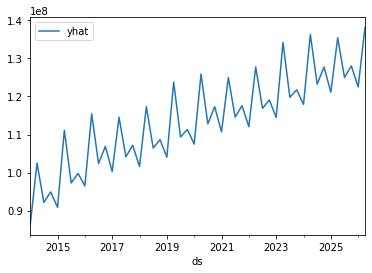

In [34]:
forecast.plot(x='ds', y='yhat')

In [35]:
def project_flat_growth(X, start="2019-04", stop="2020-03"):
    """Normalize future growth to be flat at the last annual period."""
    # Make a copy first
    X = X.copy()
    freq = X.index.inferred_freq
    X.index.freq = freq

    # This is the part that will be projected
    norm = X.loc[start:stop].copy()
    latest_date = norm.index[-1]

    # This should be monthly or quarterly
    assert len(norm) in [4, 12]
    if len(norm) == 4:
        key = lambda dt: dt.quarter
    else:
        key = lambda dt: dt.month

    # Reset the index to months/quarters
    norm.index = [key(dt) for dt in norm.index]

    # Change the forecast to be flat
    forecast_start = latest_date + latest_date.freq
    Y = X.loc[forecast_start:].copy()

    # Reset index
    i = Y.index
    Y.index = [key(dt) for dt in Y.index]

    # Overwrite
    Y.loc[:] = norm.loc[Y.index].values
    Y.index = i

    # Add back to original
    X.loc[Y.index] = Y.values

    return X

In [36]:
forecast = (
    forecast[
        [
            "ds",
            "yhat",
            "yhat_lower",
            "yhat_upper",
            "yearly",
            "trend",
        ]
    ]
    .rename(
        columns={
            "ds": "date",
            "yhat": "total",
            "yhat_lower": "lower",
            "yhat_upper": "upper",
        }
    )
    .set_index("date")
)

In [37]:
flat_forecast = project_flat_growth(forecast)

In [38]:
ratios = (unscaled_features[TAX_BASE_COLUMN] / flat_forecast["total"]).dropna()

In [39]:
ratios

2014-01-01    1.018075
2014-04-01    0.945281
2014-07-01    1.020783
2014-10-01    1.002681
2015-01-01    0.997768
2015-04-01    0.997216
2015-07-01    1.025403
2015-10-01    0.986442
2016-01-01    1.013150
2016-04-01    1.004034
2016-07-01    1.008108
2016-10-01    1.007062
2017-01-01    1.000606
2017-04-01    1.012370
2017-07-01    0.987577
2017-10-01    0.987552
2018-01-01    0.997390
2018-04-01    1.011870
2018-07-01    0.982985
2018-10-01    1.001546
2019-01-01    0.975512
2019-04-01    1.021391
2019-07-01    0.980714
2019-10-01    1.013585
2020-01-01    1.001198
2020-04-01    0.126802
2020-07-01    0.320033
2020-10-01    0.436035
2021-01-01    0.421958
2021-04-01    0.622429
dtype: float64

In [40]:
future_dates = pd.date_range("2021-07-01", "2026-06-30", freq="QS")

In [41]:
future_ratios = pd.Series(
    [
        0.60,
        0.65,
        0.70,
        0.75,
        0.80,
        0.80,
        0.80,
        0.85,
        0.85,
        0.9,
        0.9,
        0.9,
        0.9,
        0.925,
        0.925,
        0.925,
        0.95,
        0.95,
        0.95,
        0.95,
    ],
    index=future_dates,
)

In [42]:
F = flat_forecast["total"].copy()
actuals = df.set_index("ds")["y"]
F = pd.concat([F.loc["2021-07-01":], actuals])

In [43]:
inter = F.index.intersection(future_ratios.index)
F.loc[inter] *= future_ratios.loc[inter].values

In [44]:
F2 = aggregate_to_fiscal_year(F).rename(columns={"total": TAX_BASE_COLUMN}).squeeze()

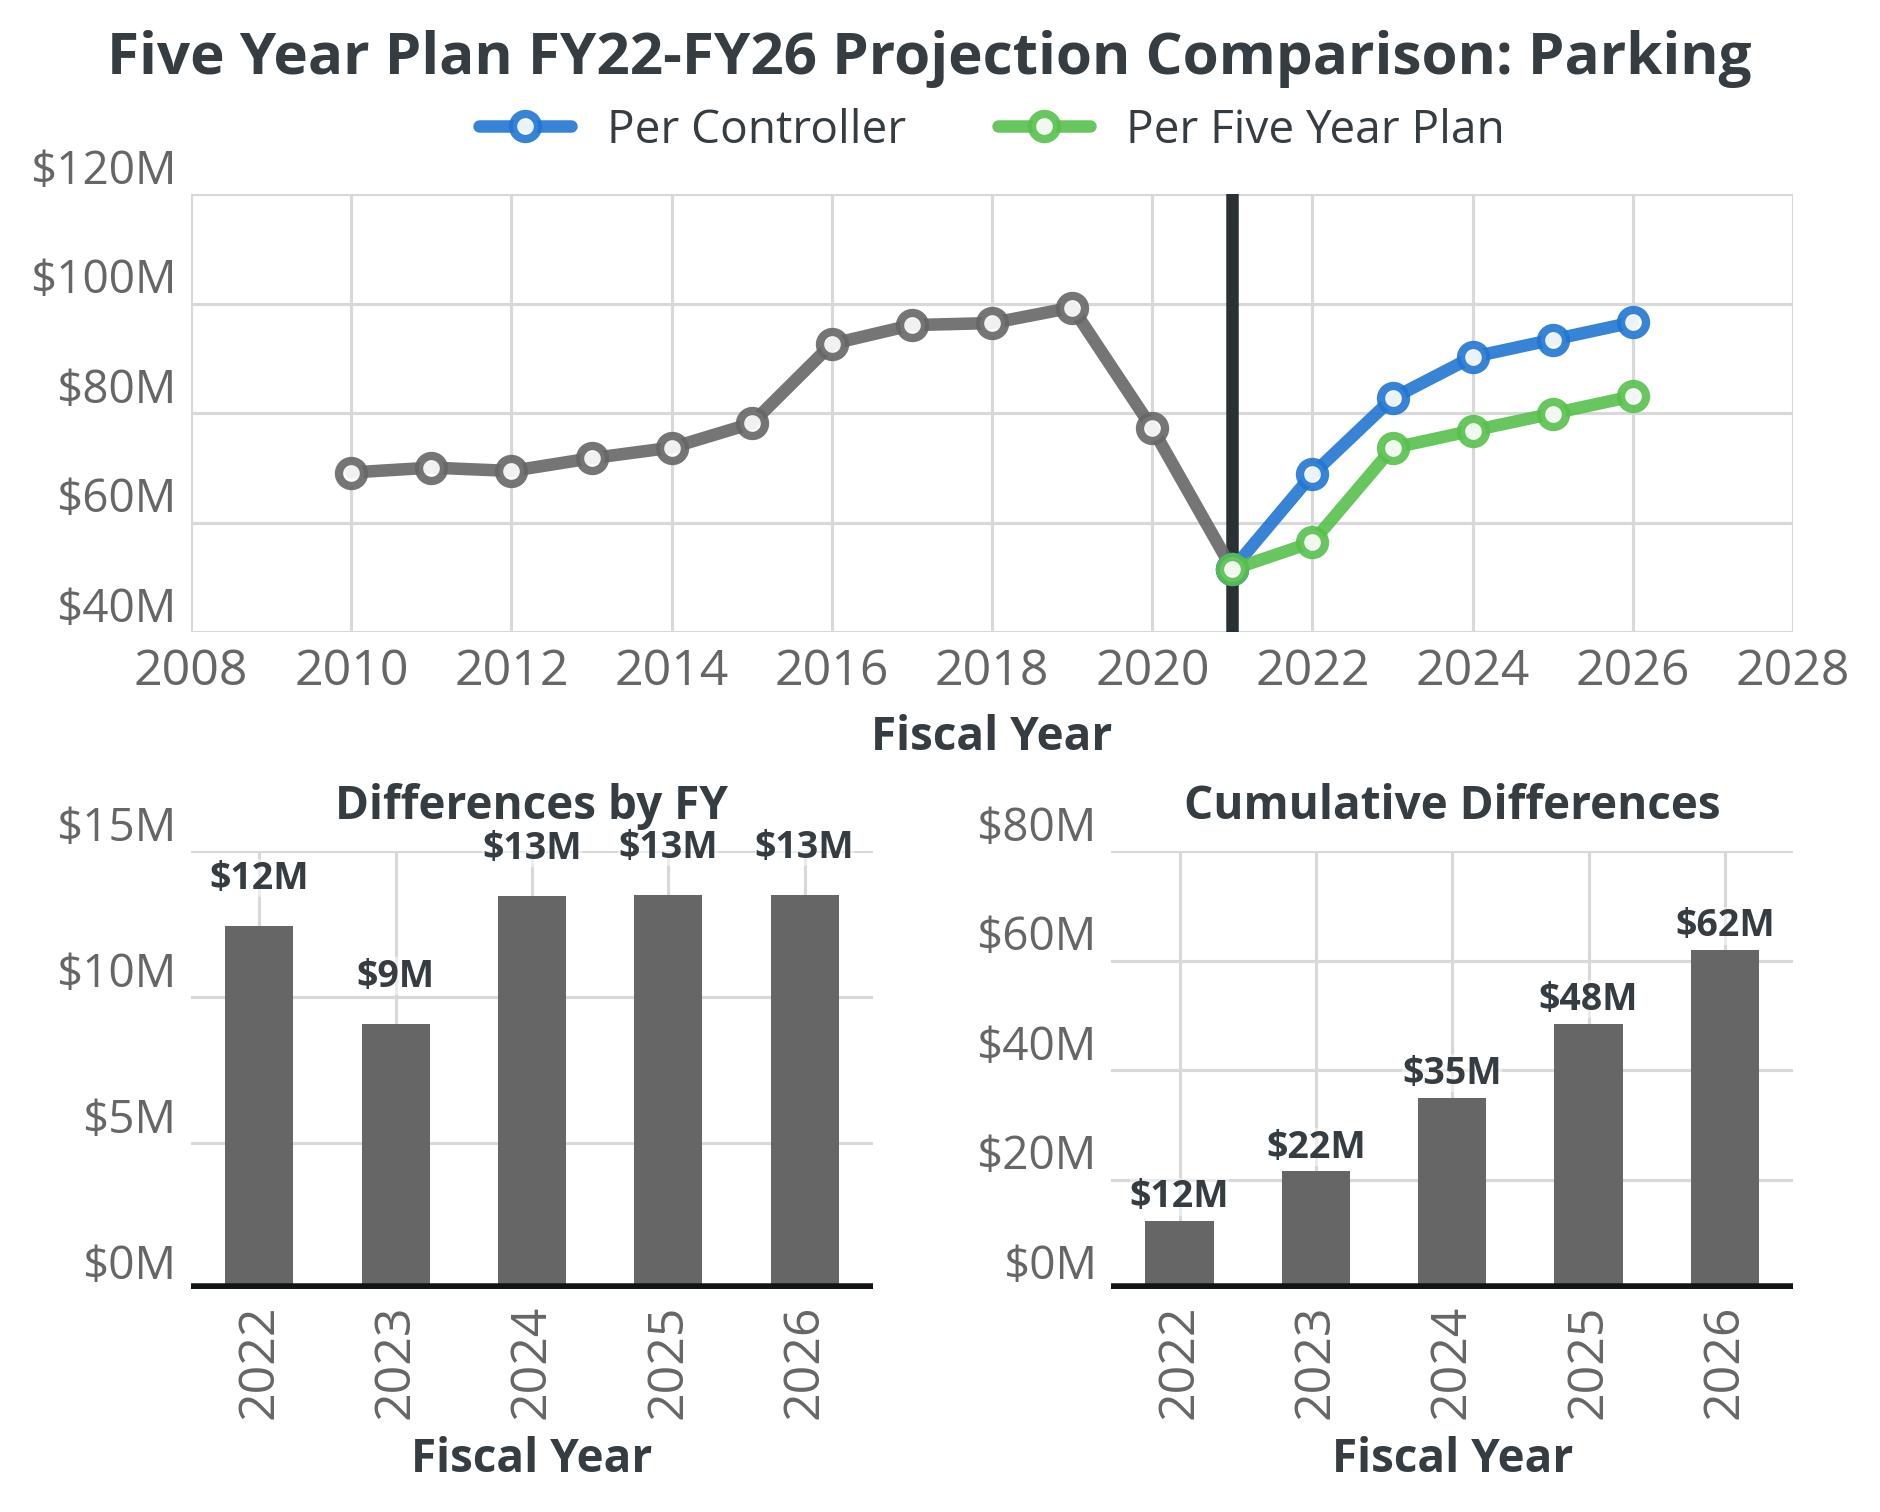

In [45]:
plot_projection_comparison(this_tax, F2.squeeze());

In [47]:
DATA.save("parking_fit_params", future_ratios)

2021-07-05 13:37:08,873 - kedro.io.data_catalog - INFO - Saving data to `parking_fit_params` (PickleDataSet)...


In [46]:
from phl_budget_data.clean import load_city_tax_collections

In [95]:
parking_tax = load_city_tax_collections().query("name == 'parking'")

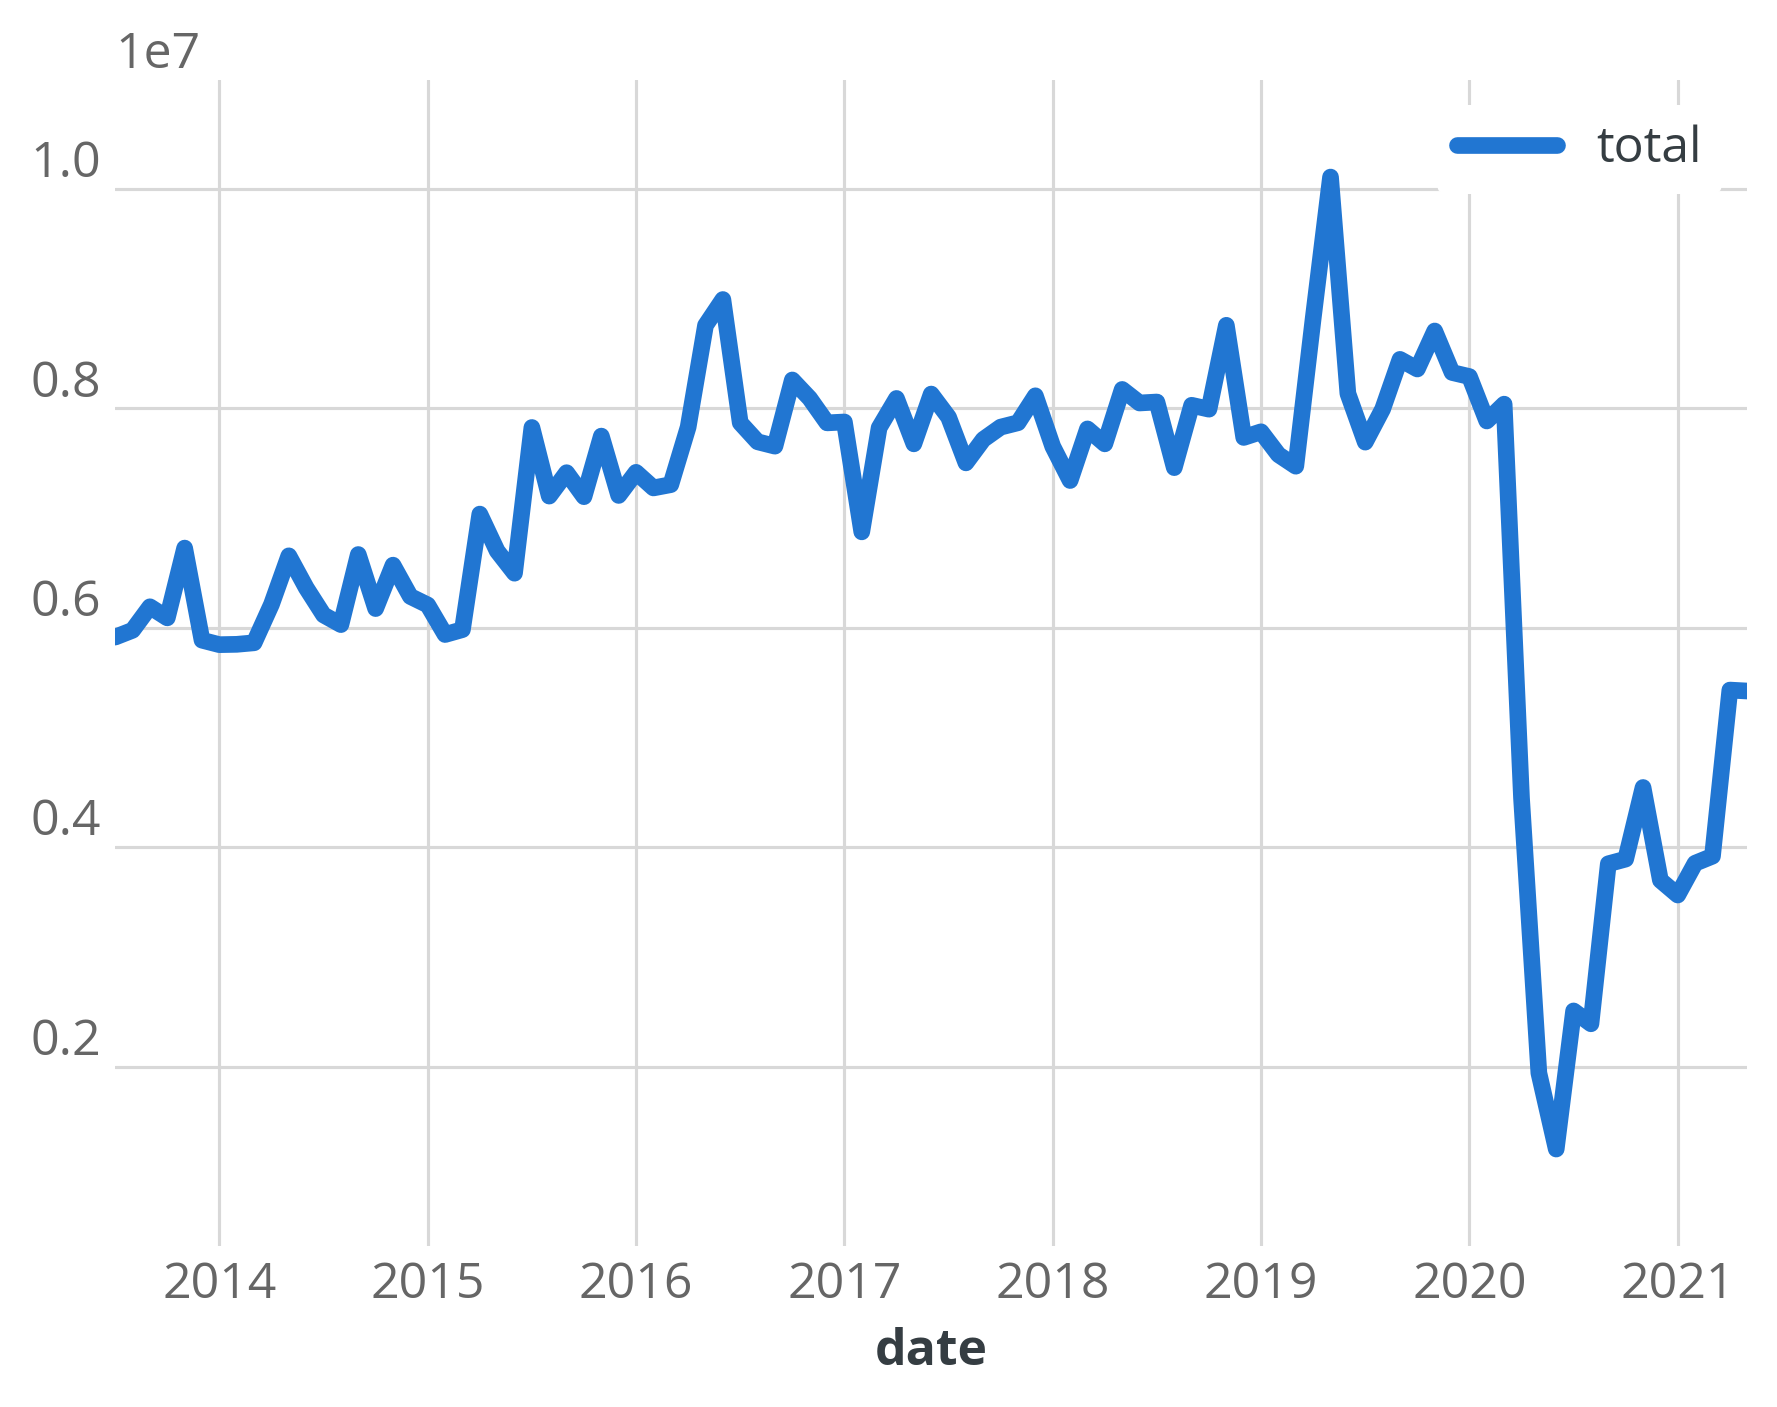

In [100]:
with plt.style.context(get_theme()):
    parking_tax.set_index("date").plot(y="total")